In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk # text preprocessing & manipulation
from functools import partial # to reduce df memory consumption by applying to_numeric

import warnings
warnings.filterwarnings('ignore') # silence annoying warnings

%matplotlib inline

color = sns.color_palette() # adjusting plotting style


In [3]:
order_fpath = "../data/orders.csv"
aisle_fpath = "../data/aisles.csv"
department_fpath = "../data/departments.csv"
product_fpath = "../data/products.csv"
op_train_fpath = "../data/order_products__train.csv"
op_prior_fpath = "../data/order_products__prior.csv"

In [10]:
aisles = pd.read_csv(aisle_fpath, header=0)
departments = pd.read_csv(department_fpath, header=0)
products = pd.read_csv(product_fpath, header=0)

train = pd.read_csv(op_train_fpath, engine='c', 
                    dtype={'order_id': np.int32, 'product_id': np.int32, 
                           'add_to_cart_order': np.int16, 'reordered': np.int8})
prior = pd.read_csv(op_prior_fpath, engine='c', 
                    dtype={'order_id': np.int32, 'product_id': np.int32, 
                           'add_to_cart_order': np.int16, 'reordered': np.int8})
orders = pd.read_csv(order_fpath, engine='c', dtype={'order_id': np.int32, 
                                            'user_id': np.int32, 
                                            'order_number': np.int32, 
                                            'order_dow': np.int8, 
                                            'order_hour_of_day': np.int8, 
                                            'days_since_prior_order': np.float16})

# combine aisles, departments and products (left joined to products)
items = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.product_name = items.product_name.str.replace(' ', '_').str.lower()

from functools import partial

# merge train and prior together iteratively, to fit into 8GB kernel RAM
# split df indexes into parts
indexes = np.linspace(0, len(op_prior), num=10, dtype=np.int32)

# initialize it with train dataset
order_details = pd.merge(left=train, right=orders, how='left', 
                         on='order_id').apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

# add order hierarchy
order_details = pd.merge(left=order_details, 
                         right=items[['product_id', 'aisle_id', 'department_id']].apply(partial(pd.to_numeric, 
                                                             errors='ignore', 
                                                             downcast='integer')), 
                         how='left',
                         on='product_id')

# delete (redundant now) dataframes
del train

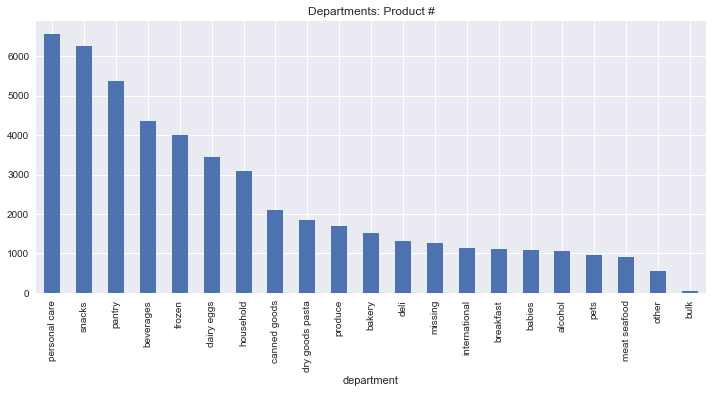

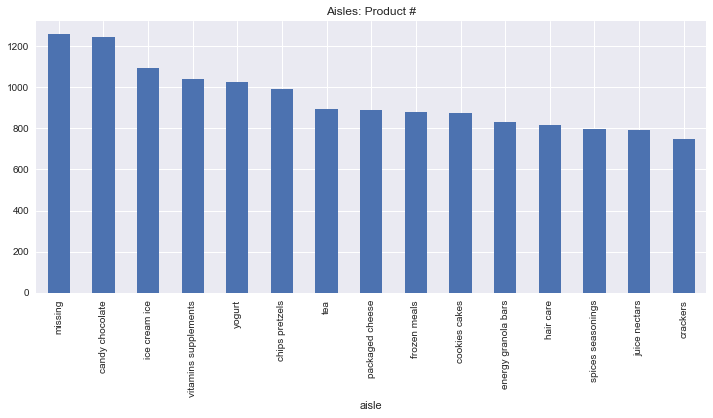

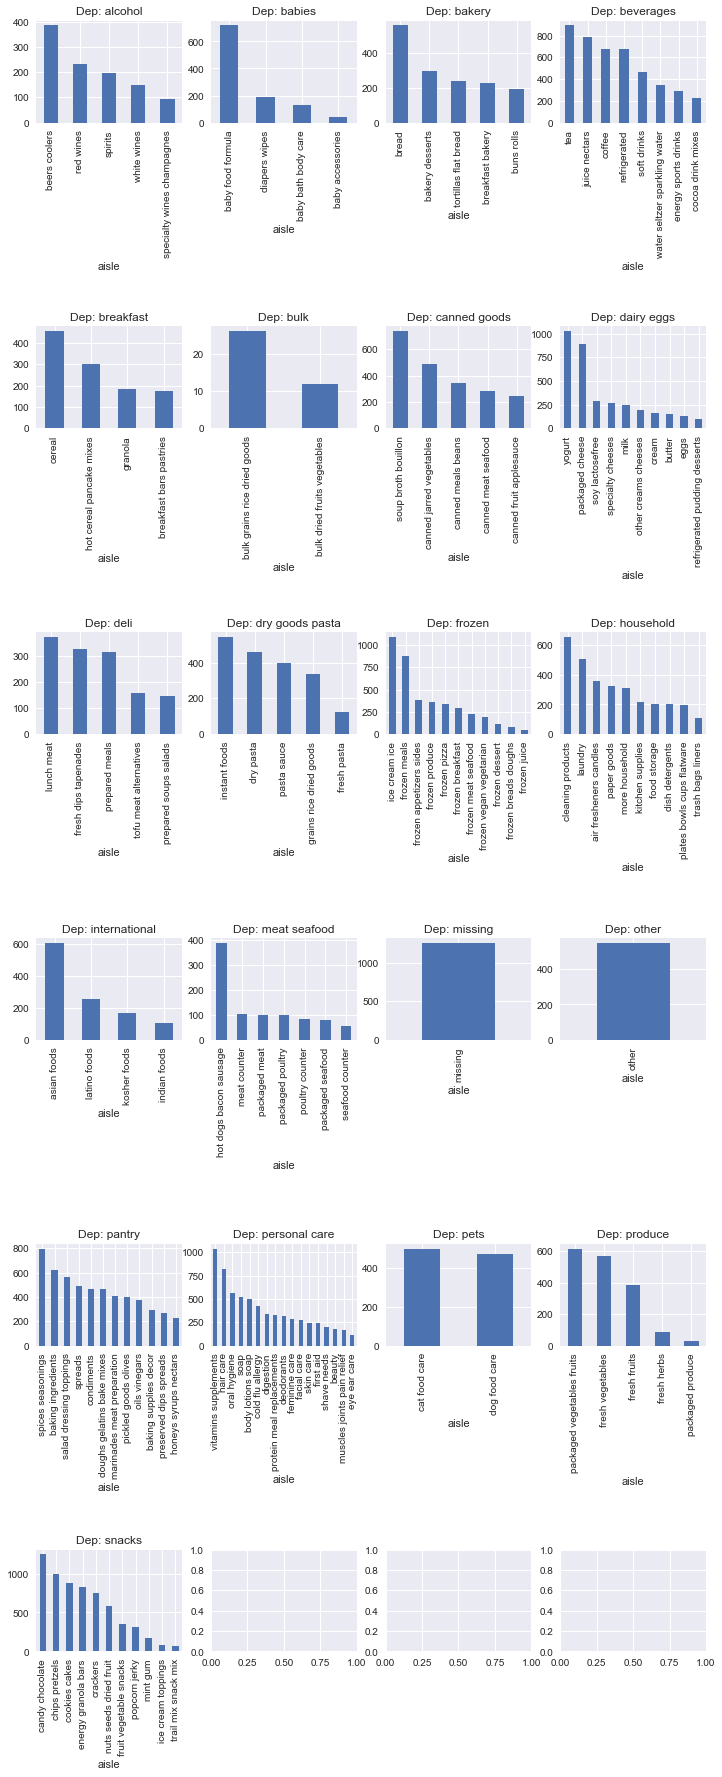

In [8]:
plt.figure(figsize=(12, 5))
items.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).plot(kind='bar', 
                                   title='Departments: Product #')


# basic group info (top-x aisles)
top_aisles_cnt = 15
plt.figure(figsize=(12, 5))
items.groupby(['aisle']).count()['product_id']\
.sort_values(ascending=False)[:top_aisles_cnt].plot(kind='bar',  
                                   title='Aisles: Product #')

# plot departments volume, split by aisles
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    items[items.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

In [18]:
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    '''Create statistical columns, group by [N columns] and compute stats on [N column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       agg_dict: python dictionary

       Return
       ------
       new pandas dataframe with original columns and new added columns
    '''
    try:
        if type(group_columns_list) == list:
            pass
        else:
            raise TypeError(k + "should be a list")
    except TypeError as e:
        print(e)
        raise

    df_new = df.copy()
    grouped = df_new.groupby(group_columns_list)

    the_stats = grouped.agg(agg_dict)
    the_stats.columns = the_stats.columns.droplevel(0)
    the_stats.reset_index(inplace=True)
    if only_new_feature:
        df_new = the_stats
    else:
        df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns
    '''
    dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

    for k, v in dicts.items():
        try:
            if type(v) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise

    grouped_name = ''.join(group_columns_list)
    target_name = ''.join(target_columns_list)
    combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

    df_new = df.copy()
    grouped = df_new.groupby(group_columns_list)

    the_stats = grouped[target_name].agg(methods_list).reset_index()
    the_stats.columns = [grouped_name] + \
                        ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                         for (grouped_name, method_name, target_name) in combine_name]
    if keep_only_stats:
        return the_stats
    else:
        df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
    return df_new

In [20]:
# Product features

prior_orders_detail = orders.merge(right=prior, how='inner', on='order_id')

# _user_buy_product_times: the n-th times user has purchased this item
prior_orders_detail.loc[:, '_user_buy_product_times'] = prior_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1

#_prod_tot_cnts: total number of times the item is purchased
# _reorder_tot_cnts_of_this_prod: number of times the item is re-purchased
agg_dict = {'user_id': {'_prod_tot_cnts': 'count'}, 
            'reordered': {'_prod_reorder_tot_cnts': 'sum'}, 
            '_user_buy_product_times': {'_prod_buy_first_time_total_cnt': lambda x: sum(x==1),
                                        '_prod_buy_second_time_total_cnt': lambda x: sum(x==2)}}
prd = ka_add_groupby_features_1_vs_n(prior_orders_detail, ['product_id'], agg_dict)

prd['_prod_reorder_prob'] = prd._prod_buy_second_time_total_cnt / prd._prod_buy_first_time_total_cnt
prd['_prod_reorder_ratio'] = prd._prod_reorder_tot_cnts / prd._prod_tot_cnts
prd['_prod_reorder_times'] = 1 + prd._prod_reorder_tot_cnts / prd._prod_buy_first_time_total_cnt

In [23]:
# User features

agg_dict_2 = {'order_number': {'_user_total_orders': 'max'},
              'days_since_prior_order': {'_user_sum_days_since_prior_order': 'sum', 
                                         '_user_mean_days_since_prior_order': 'mean'}}
users = ka_add_groupby_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

agg_dict_3 = {'reordered': {'_user_reorder_ratio': 
                           lambda x: sum(prior_orders_detail.ix[x.index, 'reordered']==1)/
                                     sum(prior_orders_detail.ix[x.index, 'order_number'] > 1)},
              'product_id': {'_user_total_products':'count', 
                             '_user_distinct_products': lambda x: x.nunique()}}
us = ka_add_groupby_features_1_vs_n(prior_orders_detail, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')

users['_user_average_basket'] = users._user_total_products / users._user_total_orders

us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')

print users.head()

   user_id  _user_mean_days_since_prior_order  \
0        1                          19.562500   
1        2                          15.234375   
2        3                          12.093750   
3        4                          13.750000   
4        5                          13.335938   

   _user_sum_days_since_prior_order  _user_total_orders  _user_total_products  \
0                             176.0                  10                    59   
1                             198.0                  14                   195   
2                             133.0                  12                    88   
3                              55.0                   5                    18   
4                              40.0                   4                    37   

   _user_distinct_products  _user_reorder_ratio  _user_average_basket  \
0                       18                    0              5.900000   
1                      102                    0             13.928571   